# Preprocessing Comparison

In this notebook, we reexamine our preprocessing and adapt it to our newly found best estimator: DecisionTreeRegressor. First, we load the required dependencies and the data.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer

from src import configuration as config
from src.features.encoder_utils import load_graph
from src.pipeline.pipeline_factory import PipelineFactory, ModelType, EvaluationType

c:\users\thomas\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the data
train_df = config.load_traindata_for_regression()
pipelineFactory = PipelineFactory()

## 0) Baseline

Let us examine the performance, when applying a OneHotEncoder for each feature.

In [3]:
from category_encoders.one_hot import OneHotEncoder

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=1,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.clear_steps()
pipeline.add_new_step(OneHotEncoder(), 'onehot')
pipeline.change_estimator(DecisionTreeRegressor())
pipeline.run()

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.4869
    validation_average_spearman_fold_1: 0.5341
    validation_average_spearman_fold_2: 0.4631
    validation_average_spearman_fold_3: 0.4709
    validation_average_spearman_fold_4: 0.4761
    average of all folds: 0.4862 [std=0.0251]


## 1) Embedding

First, we look at the embeddings for the feature 'encoder'. Our baselines are simple encodings, which ignore the underlying relations between the encoders. As embeddings, we try node2vec and different poincare variations.

In [3]:
from src.pipeline.pipeline_transformers import Node2VecEmbedding, PoincareEmbedding
from src.features.encoder_utils import load_graph

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=1,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.change_estimator(DecisionTreeRegressor())

graph = load_graph(config.ROOT_DIR / "data/external/graphs/encodings_graph.adjlist")

scores = {}

### 1.1 Baseline (OrdinalEncoder)

In [4]:
from category_encoders.ordinal import OrdinalEncoder

pipeline.add_new_step(OrdinalEncoder(cols='encoder'), 'encoder_transformer')
pipeline.run()
scores['ordinal'] = pipeline._validation_performance_scores

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.4821
    validation_average_spearman_fold_1: 0.4561
    validation_average_spearman_fold_2: 0.4292
    validation_average_spearman_fold_3: 0.4835
    validation_average_spearman_fold_4: 0.522
    average of all folds: 0.4746 [std=0.0309]


### 1.2) Baseline (OneHotEncoder)

In [5]:
from category_encoders.one_hot import OneHotEncoder

pipeline.add_new_step(OneHotEncoder(cols='encoder'), 'encoder_transformer')
pipeline.run()
scores['onehot'] = pipeline._validation_performance_scores

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.4834
    validation_average_spearman_fold_1: 0.4702
    validation_average_spearman_fold_2: 0.45
    validation_average_spearman_fold_3: 0.5004
    validation_average_spearman_fold_4: 0.5488
    average of all folds: 0.4906 [std=0.0335]


### 1.3) Baseline (TargetEncoder)

In [6]:
from category_encoders.target_encoder import TargetEncoder

pipeline.add_new_step(TargetEncoder(cols='encoder'), 'encoder_transformer')
pipeline.run()
scores['target'] = pipeline._validation_performance_scores

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.4771
    validation_average_spearman_fold_1: 0.4883
    validation_average_spearman_fold_2: 0.4517
    validation_average_spearman_fold_3: 0.4968
    validation_average_spearman_fold_4: 0.5238
    average of all folds: 0.4875 [std=0.0236]


### 1.4) Node2Vec

In [7]:
pipeline.add_new_step(Node2VecEmbedding(graph=graph, walk_length=20, num_walks=1000, workers=1), 'encoder_transformer')
pipeline.run()
scores['node2vec'] = pipeline._validation_performance_scores

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


Computing transition probabilities: 100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9025.18it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 228.81it/s]

Computing transition probabilities: 100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9026.91it/s]

Generating walks (CPU: 1):   4%|███▉                                                                                      | 44/1000 [00:00<00:04, 214.50it/s]


Computing transition probabilities: 100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9026.91it/s]

Generating walks (CPU: 1):  28%|█████████████████████████▎                                                               | 285/1000 [00:01<00:02, 249.02it/s]


Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 249.85it/s]

Computing transition probabilities: 100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9014.84it/s]

Generating walks (CPU: 1):  54%|████████████████████████████████████████████████▍                                        | 544/1000 [00:02<00:01, 242.69it/s]


Computing transition probabilities: 100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 11280.40it/s]

Generating walks (CPU: 1):  78%|█████████████████████████████████████████████████████████████████████▌                   | 781/1000 [00:03<00:00, 246.70it/s]


Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 249.11it/s]

Computing transition probabilities: 100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9026.91it/s]

Computing transition probabilities: 100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9024.32it/s]

Generating walks (CPU: 1):   0%|                                                                                                    | 0/1000 [00:00<?, ?it/s]


Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.19it/s]

Computing transition probabilities: 100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9023.46it/s]

Generating walks (CPU: 1):  29%|██████████████████████████▏                                                              | 294/1000 [00:01<00:02, 252.88it/s]


Computing transition probabilities: 100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9020.01it/s]

Generating walks (CPU: 1):  55%|█████████████████████████████████████████████████▎                                       | 554/1000 [00:02<00:01, 241.45it/s]


Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.12it/s]

Computing transition probabilities: 100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 9026.91it/s]

Generating walks (CPU: 1):  81%|████████████████████████████████████████████████████████████████████████▏                | 811/1000 [00:03<00:00, 251.05it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.44s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.0634
    validation_average_spearman_fold_1: 0.0225
    validation_average_spearman_fold_2: -0.1194
    validation_average_spearman_fold_3: 0.0891
    validation_average_spearman_fold_4: 0.0134
    average of all folds: 0.0138 [std=0.072]


### 1.5) Default Poincare

In [8]:
pipeline.add_new_step(PoincareEmbedding(graph=graph, epochs=100), 'encoder_transformer')
pipeline.run()
scores['poincare_default'] = pipeline._validation_performance_scores

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.03s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.4833
    validation_average_spearman_fold_1: 0.4762
    validation_average_spearman_fold_2: 0.4405
    validation_average_spearman_fold_3: 0.4851
    validation_average_spearman_fold_4: 0.5159
    average of all folds: 0.4802 [std=0.0241]


### 1.6) Tuned Poincare

In [9]:
pipeline.add_new_step(PoincareEmbedding(graph=graph, epochs=500, batch_size=50), 'encoder_transformer')
pipeline.run()
scores['poincare_tuned'] = pipeline._validation_performance_scores

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.91s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.491
    validation_average_spearman_fold_1: 0.4848
    validation_average_spearman_fold_2: 0.4689
    validation_average_spearman_fold_3: 0.4933
    validation_average_spearman_fold_4: 0.5119
    average of all folds: 0.49 [std=0.0139]


### 1.7) Tuned Poincare (More Epochs)

In [10]:
pipeline.add_new_step(PoincareEmbedding(graph=graph, epochs=3000, batch_size=50), 'encoder_transformer')
pipeline.run()
scores['poincare_longer'] = pipeline._validation_performance_scores

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:58<00:00, 23.62s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.4726
    validation_average_spearman_fold_1: 0.4874
    validation_average_spearman_fold_2: 0.4783
    validation_average_spearman_fold_3: 0.4973
    validation_average_spearman_fold_4: 0.5121
    average of all folds: 0.4895 [std=0.0141]


### 1.8) Tuned Poincare (Encode Feature)

In [11]:
from category_encoders.one_hot import OneHotEncoder
pipeline.add_new_step(PoincareEmbedding(graph=graph, epochs=500, batch_size=50, encoder=OneHotEncoder()), 'encoder_transformer')
pipeline.run()
scores['poincare_encode'] = pipeline._validation_performance_scores

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.77s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.4647
    validation_average_spearman_fold_1: 0.4774
    validation_average_spearman_fold_2: 0.4569
    validation_average_spearman_fold_3: 0.5085
    validation_average_spearman_fold_4: 0.525
    average of all folds: 0.4865 [std=0.0261]


### 1.9) Comparison

In [12]:
scores_df = pd.DataFrame(scores)
scores_df = scores_df.applymap(lambda x: x[0] if isinstance(x, list) else x)
scores_df.index = scores_df.index.str.replace('validation_', '')
scores_df = scores_df.rename_axis('metric')

if not (pipeline._evaluation != 'cross_validation' and pipeline._evaluation != EvaluationType.CROSS_VALIDATION):
    scores_df = pd.concat([
        scores_df, 
        pd.DataFrame(scores_df.mean(axis=0), columns=['average_spearman (5-fold)']).transpose()
    ])
    
display(scores_df)

,ordinal,onehot,target,node2vec,poincare_default,poincare_tuned,poincare_longer,poincare_encode
average_spearman_fold_0,0.482075,0.483389,0.477092,0.063423,0.483321,0.491014,0.472554,0.464730
average_spearman_fold_1,0.456116,0.470221,0.488293,0.022470,0.476173,0.484765,0.487375,0.477381
average_spearman_fold_2,0.429218,0.449989,0.451693,-0.119387,0.440514,0.468939,0.478276,0.456915
average_spearman_fold_3,0.483475,0.500353,0.496771,0.089066,0.485054,0.493269,0.497339,0.508490
average_spearman_fold_4,0.521973,0.548804,0.523782,0.013387,0.515911,0.511907,0.512072,0.525029
average_spearman (5-fold),0.474571,0.490551,0.487526,0.013792,0.480195,0.489979,0.489523,0.486509


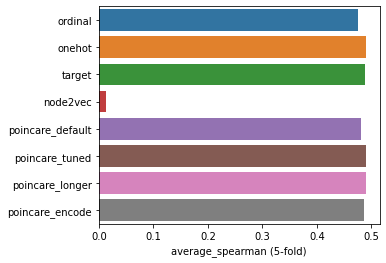

In [13]:
if pipeline._evaluation == 'basic' or pipeline._evaluation == EvaluationType.BASIC:
    for metric, values in scores_df.iterrows():
        sns.barplot(x=values, y=values.index)
        plt.gcf().subplots_adjust(left=0.25)
        plt.savefig('embeddings_comparison_' + metric + '.svg')
        plt.show()
else:
    average = scores_df.loc['average_spearman (5-fold)']
    sns.barplot(x=average, y=average.index)
    plt.gcf().subplots_adjust(left=0.25)
    plt.savefig('embeddings_comparison_.svg')
    plt.show()

In previous iterations, we saw that tuned poincare with an additional encoder performs the best. In repeated runs this trend did not hold. When we look at the standard deviation we also see that it is quite large for all evaluations, so there is no clear best strategy. When comparing the approaches to the baseline of just applying one-hot encoding to the feature 'encoder', we see that using an embedding has very little influence on the model performance. Regardless, we apply the variation with tuned poincare and additional encoding for the following steps as it was one of the best approaches.

## 2) Metafeatures

Now, we reexamine the effect of metafeatures and their processing regarding the feature 'dataset'.

In [15]:
from src.pipeline.pipeline_transformers import OpenMLMetaFeatureTransformer

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=0,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.add_new_step(PoincareEmbedding(graph=graph, epochs=500, batch_size=50, encoder=OneHotEncoder()), 'encoder_transformer')
pipeline.change_estimator(DecisionTreeRegressor())

In [16]:
scores = {}
def evaluation(nan_ratio, variance, encoder):
    print('nan_ratio:', nan_ratio, 'variance:', variance, 'encoder:', encoder, end='')
    pipeline.add_new_step(
        OpenMLMetaFeatureTransformer(
            nan_ratio_feature_drop_threshold=nan_ratio,
            expected_pca_variance=variance,
            encoder=encoder
        ), 
        'dataset_transformer'
    )
    pipeline.run()
    score = np.mean(list(pipeline._validation_performance_scores.values()))
    scores[(nan_ratio, variance, str(encoder))] = score
    print(' ->', score)

In [17]:
baselines = [
    (0, 1, None), # no metafeatues + drop dataset
    (0, 1, TargetEncoder()), # no metafeatures + encode dataset
    (1, 1, None), # all metafeatures with imputation + drop dataset
    (1, 1, TargetEncoder()) # all metafeatures with imputation + encode dataset
]
combinations = baselines + list(itertools.product(
    [0.25, 0.4, 0.45, 0.5], 
    [0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
    [None]
))

for count, (nan_ratio, variance, encoder) in enumerate(combinations):
    print('[' + str(count + 1) + '/' + str(len(combinations)) + ']' + ' ', end='')
    evaluation(nan_ratio, variance, encoder)

[1/32] nan_ratio: 0 variance: 1 encoder: None -> 0.14837434084837034
[2/32] nan_ratio: 0 variance: 1 encoder: TargetEncoder() -> 0.4711705468802555
[3/32] nan_ratio: 1 variance: 1 encoder: None -> 0.5241839360433269
[4/32] nan_ratio: 1 variance: 1 encoder: TargetEncoder() -> 0.48827217847973897
[5/32] nan_ratio: 0.25 variance: 0.6 encoder: None -> 0.5427429606825774
[6/32] nan_ratio: 0.25 variance: 0.7 encoder: None -> 0.515542735234362
[7/32] nan_ratio: 0.25 variance: 0.8 encoder: None -> 0.5072451010715778
[8/32] nan_ratio: 0.25 variance: 0.9 encoder: None -> 0.5088591429356686
[9/32] nan_ratio: 0.25 variance: 0.95 encoder: None -> 0.501166253611695
[10/32] nan_ratio: 0.25 variance: 0.99 encoder: None -> 0.4912273825715422
[11/32] nan_ratio: 0.25 variance: 1 encoder: None -> 0.5039659143697788
[12/32] nan_ratio: 0.4 variance: 0.6 encoder: None -> 0.5337547847662678
[13/32] nan_ratio: 0.4 variance: 0.7 encoder: None -> 0.537036499627334
[14/32] nan_ratio: 0.4 variance: 0.8 encoder: No

In [18]:
def without_encoder(combination):
    return (
        combination[0],
        combination[1],
        "None"
    )

def with_encoder(combination):
    return (
        combination[0],
        combination[1],
        "TargetEncoder(cols=['dataset'])"
    )

baseline_without_encoder = (0, 1, "None")
baseline_with_encoder = (0, 1, "TargetEncoder(cols=['dataset'])")

best = max(scores, key=scores.get)
best_without_encoder = without_encoder(best)
best_with_encoder = with_encoder(best)

full_imputation_scores = {k: scores[k] for k in scores if k[0] >= 0.5}
full_imputation_best = max(full_imputation_scores, key=full_imputation_scores.get)
full_imputation_best_with_encoder = with_encoder(full_imputation_best)
full_imputation_best_without_encoder = without_encoder(full_imputation_best)

no_imputation_scores = {k: scores[k] for k in scores if k[0] == 0}
no_imputation_best = max(no_imputation_scores, key=no_imputation_scores.get)
no_imputation_best_with_encoder = with_encoder(no_imputation_best)
no_imputation_best_without_encoder = without_encoder(no_imputation_best)

no_pca_scores = {k: scores[k] for k in scores if k[1] == 1}
no_pca_best = max(no_pca_scores, key=no_pca_scores.get)
no_pca_best_with_encoder = with_encoder(no_pca_best)
no_pca_best_without_encoder = without_encoder(no_pca_best)

In [23]:
scores_df = pd.DataFrame()
for nan_ratio, variance, encoder in scores:
    scores_df = pd.concat([scores_df, pd.DataFrame({
        'nan_ratio': [nan_ratio],
        'variance': [variance],
        'encoder': [encoder == "TargetEncoder(cols=['dataset'])"],
        'score': [scores[(nan_ratio, variance, encoder)]]
    })])
scores_df = scores_df.sort_values(by='score', ascending=False).reset_index(drop=True)
display(scores_df)

print('best params -> nan_ratio', scores_df.loc[0][0], 'variance', scores_df.loc[0][1], 'encoder', scores_df.loc[0][2])

,nan_ratio,variance,encoder,score
0,0.25,0.60,False,0.542743
1,0.40,0.70,False,0.537036
2,0.40,0.60,False,0.533755
3,0.45,0.80,False,0.527765
4,0.50,0.90,False,0.525485
5,0.40,0.95,False,0.525484
6,0.45,0.70,False,0.524698
7,0.50,1.00,False,0.524507
8,1.00,1.00,False,0.524184
9,0.50,0.70,False,0.523176


best params -> nan_ratio 0.25 variance 0.6 encoder False


The best parameters are a 'nan' drop threshold of 0.25 and keeping an expected variance of 0.6 regarding the pca. Let us check how encoding the 'dataset' feature, instead of just dropping it, affects the performance.

In [26]:
import category_encoders

scores = {}
for encoder in [
    None,
    category_encoders.one_hot.OneHotEncoder(),
    category_encoders.binary.BinaryEncoder(),
    category_encoders.ordinal.OrdinalEncoder(),
    category_encoders.target_encoder.TargetEncoder(),
    category_encoders.glmm.GLMMEncoder()
]:
    evaluation(0.25, 0.6, encoder)

nan_ratio: 0.25 variance: 0.6 encoder: None -> 0.5476254695454387
nan_ratio: 0.25 variance: 0.6 encoder: OneHotEncoder() -> 0.5422733114629104
nan_ratio: 0.25 variance: 0.6 encoder: BinaryEncoder() -> 0.5377620516528516
nan_ratio: 0.25 variance: 0.6 encoder: OrdinalEncoder() -> 0.5318775477612452
nan_ratio: 0.25 variance: 0.6 encoder: TargetEncoder() -> 0.47263943766212557
nan_ratio: 0.25 variance: 0.6 encoder: GLMMEncoder() -> 0.4721617490961997


In [28]:
scores_df = pd.DataFrame()
for nan_ratio, variance, encoder in scores:
    scores_df = pd.concat([scores_df, pd.DataFrame({
        'nan_ratio': [nan_ratio],
        'variance': [variance],
        'encoder': [encoder],
        'score': [scores[(nan_ratio, variance, encoder)]]
    })])
scores_df = scores_df.sort_values(by='score', ascending=False).reset_index(drop=True)
display(scores_df)

print('best params -> nan_ratio', scores_df.loc[0][0], 'variance', scores_df.loc[0][1], 'encoder', scores_df.loc[0][2])

,nan_ratio,variance,encoder,score
0,0.25,0.6,None,0.547625
1,0.25,0.6,OneHotEncoder(cols=['dataset']),0.542273
2,0.25,0.6,"BinaryEncoder(cols=['dataset'],\n ...",0.537762
3,0.25,0.6,"OrdinalEncoder(cols=['dataset'],\n ...",0.531878
4,0.25,0.6,TargetEncoder(cols=['dataset']),0.472639
5,0.25,0.6,GLMMEncoder(cols=['dataset']),0.472162


best params -> nan_ratio 0.25 variance 0.6 encoder None


We see that additionally encoding the feature is detrimental to the performance, so instead we stick to the original implementation and just drop it after adding the metafeatures. The found optimal parameter can be used as a starting point in further hyperparameter tuning.

## 3) General Purpose Encoders

In this step, we reexamine the effect of applying different general purpose encoders on the features 'model', 'tuning' and 'scoring'.

In [3]:
from category_encoders.one_hot import OneHotEncoder
from src.pipeline.pipeline_transformers import PoincareEmbedding, GeneralPurposeEncoderTransformer, OpenMLMetaFeatureTransformer
from src.features.encoder_utils import load_graph

graph = load_graph(config.ROOT_DIR / "data/external/graphs/encodings_graph.adjlist")

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=0,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.add_new_step(PoincareEmbedding(
    graph=graph, 
    epochs=500, 
    batch_size=50, 
    encoder=OneHotEncoder()
), 'encoder_transformer')
pipeline.add_new_step(OpenMLMetaFeatureTransformer(
    nan_ratio_feature_drop_threshold=0.25,
    expected_pca_variance=0.6,
    encoder=None
), 'dataset_transformer')
pipeline.change_estimator(DecisionTreeRegressor())

In [4]:
import category_encoders
from itertools import product

encoders = [
    category_encoders.ordinal.OrdinalEncoder,
    category_encoders.one_hot.OneHotEncoder,
    category_encoders.binary.BinaryEncoder,
    category_encoders.target_encoder.TargetEncoder
]

encoder_triples = list(product(encoders, repeat=3))

In [9]:
scores = {}
for idx, (model_encoder, tuning_encoder, scoring_encoder) in enumerate(encoder_triples):
    pipeline.add_new_step(GeneralPurposeEncoderTransformer(
        model_encoder=model_encoder(),
        tuning_encoder=tuning_encoder(),
        scoring_encoder=scoring_encoder()
    ), 'general_transformer')
    print('[' + str(idx + 1) + '/' + str(len(encoder_triples)) + '] ' 
          + str(model_encoder.__name__) 
          + ', ' + str(tuning_encoder.__name__)
          + ', ' + str(scoring_encoder.__name__)
    , end='')
    pipeline.run()
    score = np.mean(list(pipeline._validation_performance_scores.values()))
    scores[(str(model_encoder.__name__), str(tuning_encoder.__name__), str(scoring_encoder.__name__))] = score
    print(' ->', score)

[1/64] OrdinalEncoder, OrdinalEncoder, OrdinalEncoder -> 0.5396424042114842
[2/64] OrdinalEncoder, OrdinalEncoder, OneHotEncoder -> 0.5404931359916217
[3/64] OrdinalEncoder, OrdinalEncoder, BinaryEncoder -> 0.5431700728812603
[4/64] OrdinalEncoder, OrdinalEncoder, TargetEncoder -> 0.5492273465421788
[5/64] OrdinalEncoder, OneHotEncoder, OrdinalEncoder -> 0.5408140388803778
[6/64] OrdinalEncoder, OneHotEncoder, OneHotEncoder -> 0.5325334233805487
[7/64] OrdinalEncoder, OneHotEncoder, BinaryEncoder -> 0.5342106608737401
[8/64] OrdinalEncoder, OneHotEncoder, TargetEncoder -> 0.5429421498787328
[9/64] OrdinalEncoder, BinaryEncoder, OrdinalEncoder -> 0.5550186718237364
[10/64] OrdinalEncoder, BinaryEncoder, OneHotEncoder -> 0.5440314995914578
[11/64] OrdinalEncoder, BinaryEncoder, BinaryEncoder -> 0.5494660769601762
[12/64] OrdinalEncoder, BinaryEncoder, TargetEncoder -> 0.5567149227416995
[13/64] OrdinalEncoder, TargetEncoder, OrdinalEncoder -> 0.541159646065904
[14/64] OrdinalEncoder, Tar

In [12]:
scores_df = pd.DataFrame()
for (model_encoder, tuning_encoder, scoring_encoder), score in scores.items():
    scores_df = pd.concat([scores_df, pd.DataFrame({
        'model': [model_encoder],
        'tuning': [tuning_encoder],
        'scoring': [scoring_encoder],
        'score': [score]
    })])
scores_df = scores_df.sort_values(by='score', ascending=False).reset_index(drop=True)
display(scores_df)

print('best params -> model:', scores_df.loc[0][0], 'tuning:', scores_df.loc[0][1], 'scoring:', scores_df.loc[0][2])

,model,tuning,scoring,score
0,OneHotEncoder,TargetEncoder,TargetEncoder,0.578534
1,OneHotEncoder,BinaryEncoder,TargetEncoder,0.577829
2,OneHotEncoder,BinaryEncoder,OrdinalEncoder,0.577088
3,OneHotEncoder,OrdinalEncoder,TargetEncoder,0.574434
4,OneHotEncoder,TargetEncoder,OrdinalEncoder,0.572639
...,...,...,...,...
59,OrdinalEncoder,OneHotEncoder,OneHotEncoder,0.532533
60,BinaryEncoder,BinaryEncoder,OneHotEncoder,0.530802
61,BinaryEncoder,OneHotEncoder,OneHotEncoder,0.528825
62,BinaryEncoder,OneHotEncoder,BinaryEncoder,0.528810


best params -> model: OneHotEncoder tuning: TargetEncoder scoring: TargetEncoder


The encoders with the best performance are OneHotEncoder for the 'model' feature and TargetEncoder for the 'tuning' and 'scoring' features.

## 4) Conclusion

Let us recap and compare the current performance to different baselines.

In [30]:
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from src.pipeline.pipeline_transformers import PoincareEmbedding, GeneralPurposeEncoderTransformer, OpenMLMetaFeatureTransformer
from src.features.encoder_utils import load_graph

graph = load_graph(config.ROOT_DIR / "data/external/graphs/encodings_graph.adjlist")

scores = {
    'baseline': {},
    'preprocessing (old)': {},
    'preprocessing (new)': {}
}

In [32]:
pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=1,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.clear_steps()
pipeline.add_new_step(OneHotEncoder(), 'onehot')
pipeline.run()
scores['baseline']['lgbm'] = np.mean(list(pipeline._validation_performance_scores.values()))

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.43s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.2216
    validation_average_spearman_fold_1: 0.2309
    validation_average_spearman_fold_2: 0.2191
    validation_average_spearman_fold_3: 0.2241
    validation_average_spearman_fold_4: 0.2366
    average of all folds: 0.2265 [std=0.0064]


In [33]:
pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=1,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.clear_steps()
pipeline.add_new_step(OneHotEncoder(), 'onehot')
pipeline.change_estimator(DecisionTreeRegressor())
pipeline.run()
scores['baseline']['decision tree'] = np.mean(list(pipeline._validation_performance_scores.values()))

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.4917
    validation_average_spearman_fold_1: 0.5295
    validation_average_spearman_fold_2: 0.4396
    validation_average_spearman_fold_3: 0.468
    validation_average_spearman_fold_4: 0.5002
    average of all folds: 0.4858 [std=0.0303]


In [34]:
pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=1,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.run()
scores['preprocessing (old)']['lgbm'] = np.mean(list(pipeline._validation_performance_scores.values()))

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.24s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.2868
    validation_average_spearman_fold_1: 0.3285
    validation_average_spearman_fold_2: 0.3057
    validation_average_spearman_fold_3: 0.2972
    validation_average_spearman_fold_4: 0.3195
    average of all folds: 0.3075 [std=0.015]


In [35]:
pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=1,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.change_estimator(DecisionTreeRegressor())
pipeline.run()
scores['preprocessing (old)']['decision tree'] = np.mean(list(pipeline._validation_performance_scores.values()))

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.89s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.4753
    validation_average_spearman_fold_1: 0.473
    validation_average_spearman_fold_2: 0.4648
    validation_average_spearman_fold_3: 0.4836
    validation_average_spearman_fold_4: 0.5227
    average of all folds: 0.4839 [std=0.0203]


In [36]:
pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=1,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.add_new_step(PoincareEmbedding(
    graph=graph, 
    epochs=500, 
    batch_size=50, 
    encoder=OneHotEncoder()
), 'encoder_transformer')
pipeline.add_new_step(OpenMLMetaFeatureTransformer(
    nan_ratio_feature_drop_threshold=0.25,
    expected_pca_variance=0.6,
    encoder=None
), 'dataset_transformer')
pipeline.add_new_step(GeneralPurposeEncoderTransformer(
    model_encoder=OneHotEncoder(),
    tuning_encoder=TargetEncoder(),
    scoring_encoder=TargetEncoder()
), 'general_transformer')
pipeline.run()
scores['preprocessing (new)']['lgbm'] = np.mean(list(pipeline._validation_performance_scores.values()))

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.85s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.2821
    validation_average_spearman_fold_1: 0.3006
    validation_average_spearman_fold_2: 0.2942
    validation_average_spearman_fold_3: 0.2968
    validation_average_spearman_fold_4: 0.3042
    average of all folds: 0.2956 [std=0.0075]


In [37]:
pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.REGRE_PREPROCESSED,
    verbose_level=1,
    evaluation=EvaluationType.CROSS_VALIDATION
)
pipeline.add_new_step(PoincareEmbedding(
    graph=graph, 
    epochs=500, 
    batch_size=50, 
    encoder=OneHotEncoder()
), 'encoder_transformer')
pipeline.add_new_step(OpenMLMetaFeatureTransformer(
    nan_ratio_feature_drop_threshold=0.25,
    expected_pca_variance=0.6,
    encoder=None
), 'dataset_transformer')
pipeline.add_new_step(GeneralPurposeEncoderTransformer(
    model_encoder=OneHotEncoder(),
    tuning_encoder=TargetEncoder(),
    scoring_encoder=TargetEncoder()
), 'general_transformer')
pipeline.change_estimator(DecisionTreeRegressor())
pipeline.run()
scores['preprocessing (new)']['decision tree'] = np.mean(list(pipeline._validation_performance_scores.values()))

Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.98s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.5798
    validation_average_spearman_fold_1: 0.5769
    validation_average_spearman_fold_2: 0.5756
    validation_average_spearman_fold_3: 0.5739
    validation_average_spearman_fold_4: 0.5834
    average of all folds: 0.5779 [std=0.0034]


In [40]:
scores_df = pd.DataFrame()
for variation in scores:
    for estimator in scores[variation]:
        scores_df = pd.concat([
            scores_df,
            pd.DataFrame({'type': [variation], 'estimator': [estimator], 'score': [scores[variation][estimator]]})
        ])
scores_df = scores_df.reset_index(drop=True)

display(scores_df)

,type,estimator,score
0,baseline,lgbm,0.226457
1,baseline,decision tree,0.485808
2,preprocessing (old),lgbm,0.307539
3,preprocessing (old),decision tree,0.483875
4,preprocessing (new),lgbm,0.295593
5,preprocessing (new),decision tree,0.577929


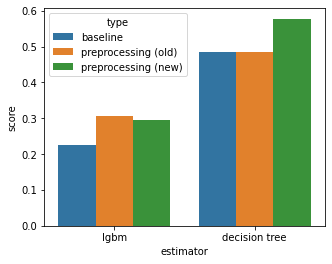

In [42]:
sns.barplot(data=scores_df, x='estimator', y='score', hue='type')
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('estimator_comparison.svg')
plt.show()

We again observe, that the decision tree regressor performes way better than the lgbm regressor. Also, our adjusted preprocessing improves the performance significantly regarding the decision tree. We also beat the baseline of just applying one-hot encoding to all features by a huge margin. The next step would be to apply hyperparameter tuning on our pipeline.